DistArray: Distributed Arrays for Python
========================================

[docs.enthought.com/distarray](http://docs.enthought.com/distarray)

Setup
-----
Much of this notebook requires an `IPython.parallel` cluster to be running.
Outside the notebook, run
```
dacluster start -n4
```

In [1]:
# some utility imports
from __future__ import print_function
from pprint import pprint
from matplotlib import pyplot as plt

# main imports
import numpy
import distarray

# reduce precision on printed array values
numpy.set_printoptions(precision=2)

# display figures inline
%matplotlib inline

### Software Versions

In [2]:
print("numpy", numpy.__version__)
import matplotlib
print("matplotlib", matplotlib.__version__)
import h5py
print("h5py", h5py.__version__)
print("distarray", distarray.__version__)

numpy 1.9.3
matplotlib 1.4.3
h5py 2.5.0
distarray 0.6.0-dev


### Set a RandomState

Set a `RandomState` so random numpy arrays don't change between runs.

In [3]:
from numpy.random import RandomState
prng = RandomState(1234567890)

NumPy Arrays
------------

DistArray is built on NumPy and provides a NumPy-array-like interface.  First, let's generate a NumPy array and examine some of its attributes.

In [4]:
# a 4-row 5-column NumPy array with random contents
nparr = prng.rand(4, 5)
nparr

array([[ 0.62,  0.59,  0.89,  0.89,  0.46],
       [ 0.78,  0.27,  1.  ,  0.54,  0.54],
       [ 0.4 ,  0.71,  0.41,  0.95,  0.03],
       [ 0.14,  0.08,  0.42,  0.23,  0.75]])

In [5]:
# NumPy array attributes
print("type:", type(nparr))
print("dtype:", nparr.dtype)
print("ndim:", nparr.ndim)
print("shape:", nparr.shape)
print("itemsize:", nparr.itemsize)
print("nbytes:", nparr.nbytes)

type: <type 'numpy.ndarray'>
dtype: float64
ndim: 2
shape: (4, 5)
itemsize: 8
nbytes: 160


DistArrays
----------

We'll make our first `DistArray` out of the NumPy array created above.

In [6]:
# First we need a `Context` object.  More on this later.
# For now, think of this object like the `NumPy` module.
# `Context`s manage the worker engines for us.
from distarray.globalapi import Context
context = Context()

In [7]:
# Make a DistArray from a NumPy array.
# This will push sections of the original NumPy array out
# to the engines.
darr = context.fromarray(nparr)
darr

<DistArray(shape=(4, 5), targets=[0, 1, 2, 3])>

In [8]:
# Print the array section stored on each engine
for i, a in enumerate(darr.get_localarrays()):
    print(i, a)

0 [[ 0.62  0.59  0.89  0.89  0.46]]
1 [[ 0.78  0.27  1.    0.54  0.54]]
2 [[ 0.4   0.71  0.41  0.95  0.03]]
3 [[ 0.14  0.08  0.42  0.23  0.75]]


In [9]:
# DistArrays have similar attributes to NumPy arrays,
print("type:", type(darr))
print("dtype:", darr.dtype)
print("ndim:", darr.ndim)
print("shape:", darr.shape)
print("itemsize:", darr.itemsize)
print("nbytes:", darr.nbytes)

type: <class 'distarray.globalapi.distarray.DistArray'>
dtype: float64
ndim: 2
shape: (4, 5)
itemsize: 8
nbytes: 160


In [10]:
# and some additional attributes.
print("targets:", darr.targets)
print("context:", darr.context)
print("distribution:", darr.distribution)

targets: [0, 1, 2, 3]
context: <distarray.globalapi.context.IPythonContext object at 0x109482450>
distribution: <distarray.globalapi.maps.Distribution object at 0x10958ba50>


Universal Functions (ufuncs)
----------------------------

In [11]:
# NumPy provides `ufuncs`, or Universal Functions, that operate
# elementwise over NumPy arrays.
numpy.sin(nparr)

array([[ 0.58,  0.56,  0.78,  0.78,  0.44],
       [ 0.7 ,  0.26,  0.84,  0.51,  0.51],
       [ 0.39,  0.65,  0.39,  0.81,  0.03],
       [ 0.14,  0.08,  0.41,  0.23,  0.68]])

In [12]:
# DistArray provides ufuncs as well, for `DistArray`s.
import distarray.globalapi as da
da.sin(darr)

<DistArray(shape=(4, 5), targets=[0, 1, 2, 3])>

In [13]:
# `toarray` makes a NumPy array out of a DistArray, pulling all of the
# pieces back to the client.  We do this to display the contents of the
# DistArray.
da.sin(darr).toarray()

array([[ 0.58,  0.56,  0.78,  0.78,  0.44],
       [ 0.7 ,  0.26,  0.84,  0.51,  0.51],
       [ 0.39,  0.65,  0.39,  0.81,  0.03],
       [ 0.14,  0.08,  0.41,  0.23,  0.68]])

In [14]:
# A NumPy binary ufunc.
nparr + nparr

array([[ 1.24,  1.18,  1.78,  1.78,  0.92],
       [ 1.56,  0.53,  1.99,  1.08,  1.08],
       [ 0.8 ,  1.41,  0.81,  1.9 ,  0.06],
       [ 0.27,  0.17,  0.85,  0.47,  1.49]])

In [15]:
# The equivalent DistArray ufunc.
# Notice that a new DistArray is created without
# pulling data back to the client.
darr + darr

<DistArray(shape=(4, 5), targets=[0, 1, 2, 3])>

In [16]:
# Contents of the resulting DistArray.
(darr + darr).toarray()

array([[ 1.24,  1.18,  1.78,  1.78,  0.92],
       [ 1.56,  0.53,  1.99,  1.08,  1.08],
       [ 0.8 ,  1.41,  0.81,  1.9 ,  0.06],
       [ 0.27,  0.17,  0.85,  0.47,  1.49]])

Reductions
----------

Functions like `sum`, `mean`, `min`, and `max` are known as *reductions*, since they take an array and produce a smaller array or a scalar.  In NumPy and DistArray, some of these functions can be applied over a specific ``axis``.

In [17]:
# NumPy sum
print("sum:", nparr.sum())
print("sum over an axis:", nparr.sum(axis=1))

sum: 10.6840911511
sum over an axis: [ 3.45  3.12  2.49  1.62]


In [18]:
# DistArray sum
print("sum:", darr.sum(), darr.sum().toarray())
print("sum over an axis:", darr.sum(axis=1), darr.sum(axis=1).toarray())

sum: <DistArray(shape=(), targets=[0])> 10.6840911511
sum over an axis: <DistArray(shape=(4,), targets=[0, 1, 2, 3])> [ 3.45  3.12  2.49  1.62]


Indexing and Slicing
--------------------

DistArrays support standard NumPy Indexing and distributed slicing, including slices with a step.  Slicing is currently only supported for Block (and undistributed) DistArrays.

In [19]:
# Our example array, as a reminder:
darr.toarray()

array([[ 0.62,  0.59,  0.89,  0.89,  0.46],
       [ 0.78,  0.27,  1.  ,  0.54,  0.54],
       [ 0.4 ,  0.71,  0.41,  0.95,  0.03],
       [ 0.14,  0.08,  0.42,  0.23,  0.75]])

In [20]:
# The shapes of the local sections of our DistArray
darr.localshapes()

[(1, 5), (1, 5), (1, 5), (1, 5)]

In [21]:
# Return the value of a single element
darr[0, 2]

0.88868358904449662

In [22]:
# Take a column slice
darr_view = darr[:, 3]  # all rows, third column
print(darr_view)
print(darr_view.toarray())

<DistArray(shape=(4,), targets=[0, 1, 2, 3])>
[ 0.89  0.54  0.95  0.23]


In [23]:
# Slices return a new DistArray that is a view on the
# original, just like in NumPy.
# Changes in the view change the original array.
darr_view[3] = -0.99
print("view:")
print(darr_view.toarray())

print("original:")
print(darr.toarray())

view:
[ 0.89  0.54  0.95 -0.99]
original:
[[ 0.62  0.59  0.89  0.89  0.46]
 [ 0.78  0.27  1.    0.54  0.54]
 [ 0.4   0.71  0.41  0.95  0.03]
 [ 0.14  0.08  0.42 -0.99  0.75]]


In [24]:
# A more complex slice, with negative indices and a step.
print(darr[:, 2::2])
print(darr[:-1, 2::2].toarray())

<DistArray(shape=(4, 2), targets=[0, 1, 2, 3])>
[[ 0.89  0.46]
 [ 1.    0.54]
 [ 0.41  0.03]]


In [25]:
# Incomplete indexing
# Grab the first row
darr[0]

<DistArray(shape=(5,), targets=[0])>

Distributions
-------------
Above, when we created a DistArray out of a NumPy array, we didn't specify *how* the elements should be distributed among our engines.  `Distribution`s give you control over this, if you want it.  In other words, `Distribution`s control which processes own which (global) indices.

In [26]:
# Let's look at the `Distribution` object that was created for us
# automatically by `fromarray`.
distribution = darr.distribution

In [27]:
# This is a 2D distribution: its 0th dimension is Block-distributed,
# and it's 1st dimension isn't distributed.
pprint(distribution.maps)

<DistArray(shape=(4, 5), targets=[0, 1, 2, 3])>

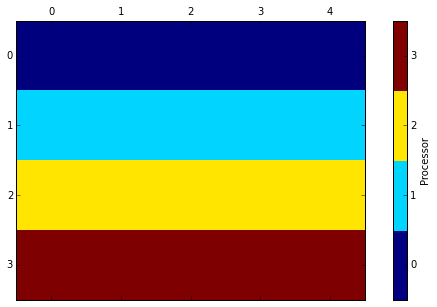

In [28]:
# Plot this Distribution, color-coding which process each global index
# belongs to.
from distarray.plotting import plot_array_distribution
process_coords = [(0, 0), (1, 0), (2, 0), (3, 0)]
plot_array_distribution(darr, process_coords, cell_label=False, legend=True)

In [29]:
# Check out which sections of this array's 0th dimension are on
# each process.
distribution.maps[0].bounds

[(0, 1), (1, 2), (2, 3), (3, 4)]

The Distribution above was created for us by `fromarray`,
but DistArray lets us specify more complex distributions.

Here, we specify that the 0th dimension has a Block distribution ('b')
and the 1st dimension has a Cyclic distribution.

DistArray supports Block, Cyclic, Block-Cyclic, Unstructured,
and No-distribution dimensions.  See the
[ScaLAPACK Documentation](http://netlib.org/scalapack/slug/node75.html) for more information about Distribution types.

<DistArray(shape=(64, 64), targets=[0, 1, 2, 3])>

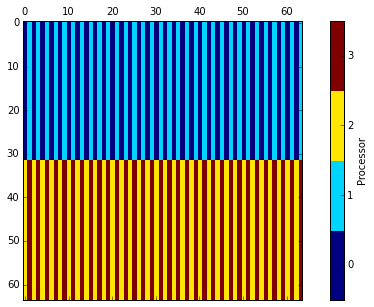

In [30]:
from distarray.globalapi import Distribution

distribution = Distribution(context, shape=(64, 64), dist=('b', 'c'))
a = context.zeros(distribution, dtype='int32')
plot_array_distribution(a, process_coords, cell_label=False, legend=True)

Redistribution
--------------

Since `DistArray`s are distributed, the equivalent to NumPy's `reshape` (`distribute_as`) can be a more complex and costly operation.  For convenience, you can supply either a `shape` or a full `Distribution` object.  Only Block distributions (and No-dist) are currently redistributable.

In [31]:
darr

<DistArray(shape=(4, 5), targets=[0, 1, 2, 3])>

In [32]:
darr.toarray()

array([[ 0.62,  0.59,  0.89,  0.89,  0.46],
       [ 0.78,  0.27,  1.  ,  0.54,  0.54],
       [ 0.4 ,  0.71,  0.41,  0.95,  0.03],
       [ 0.14,  0.08,  0.42, -0.99,  0.75]])

In [33]:
# simple reshaping
reshaped = darr.distribute_as((10, 2))
reshaped

<DistArray(shape=(10, 2), targets=[0, 1, 2, 3])>

In [34]:
reshaped.toarray()

array([[ 0.62,  0.59],
       [ 0.89,  0.89],
       [ 0.46,  0.78],
       [ 0.27,  1.  ],
       [ 0.54,  0.54],
       [ 0.4 ,  0.71],
       [ 0.41,  0.95],
       [ 0.03,  0.14],
       [ 0.08,  0.42],
       [-0.99,  0.75]])

In [35]:
# A more complex resdistribution,
# changing shape, dist, and targets
dist = Distribution(context, shape=(5, 4),
                    dist=('b', 'b'), targets=(1, 3))
darr.distribute_as(dist)

<DistArray(shape=(5, 4), targets=[1, 3])>

Contexts
--------
Context objects manage the setup of and communication to the worker processes for DistArray objects.  They also act as the namespace to which
DistArray creation functions are attached.

In [36]:
print("targets:", context.targets)
print("comm:", context.comm)

targets: [0, 1, 2, 3]
comm: <distarray.localapi.proxyize.Proxy object at 0x109597850>


In [37]:
context.zeros((5, 3))

<DistArray(shape=(5, 3), targets=[0, 1, 2])>

In [38]:
context.ones((20, 20))

<DistArray(shape=(20, 20), targets=[0, 1, 2, 3])>

Parallel IO
-----------

DistArray has support for reading NumPy `.npy` files in parallel, for reading *and* writing `.dnpy` files in parallel (our own flat-file format), and reading and writing HDF5 files in parallel (if you have a parallel build of `h5py`).

In [39]:
# load .npy files in parallel
numpy.save("/tmp/outfile.npy", nparr)
distribution = Distribution(context, nparr.shape) 
new_darr = context.load_npy("/tmp/outfile.npy", distribution)
new_darr

<DistArray(shape=(4, 5), targets=[0, 1, 2, 3])>

In [40]:
# save to .dnpy (a built-in flat-file format based on .npy)
context.save_dnpy("/tmp/outfile", darr)

In [41]:
# load from .dnpy
context.load_dnpy("/tmp/outfile")

<DistArray(shape=(4, 5), targets=[0, 1, 2, 3])>

In [42]:
# save DistArrays to .hdf5 files in parallel
context.save_hdf5("/tmp/outfile.hdf5", darr, mode='w')

In [43]:
# load DistArrays from .hdf5 files in parallel (using h5py)
context.load_hdf5("/tmp/outfile.hdf5", distribution)

<DistArray(shape=(4, 5), targets=[0, 1, 2, 3])>

Context.apply
-------------

Global view, local control.  The `apply` method on a `Context` allows you to write functions that are applied *locally* (that is, on the engines) to each section of a DistArray.  This allows you to push your computation close to your data, avoiding communication round-trips and possibly speeding up your computations.

In [44]:
def get_local_random():
    """Function to be applied locally."""
    import numpy
    return numpy.random.randint(10)

context.apply(get_local_random)

[2, 5, 8, 2]

In [45]:
def get_local_var(darr):
    """Another local computation."""
    return darr.ndarray.var()

context.apply(get_local_var, args=(darr.key,))

[0.029782447186009097,
 0.060831768443372111,
 0.096730856076473776,
 0.3423050023674285]

Context.register
----------------

`Context.register` is similar to `Context.apply`, but it allows you to *register* your function with a `Context` up front, and then call it repeatedly, with a nice syntax.

In [46]:
def local_demean(la):
    """Return the local array with the mean removed."""
    return la.ndarray - la.ndarray.mean()
context.register(local_demean)

In [47]:
context.local_demean(darr)

[array([[-0.07, -0.1 ,  0.2 ,  0.2 , -0.23]]),
 array([[ 0.15, -0.36,  0.37, -0.08, -0.09]]),
 array([[-0.1 ,  0.21, -0.09,  0.45, -0.47]]),
 array([[ 0.06,  0.  ,  0.34, -1.07,  0.67]])]

MPI-only Execution
-------------------------

Instead of using an IPython client (which uses ZeroMQ to communicate to the engines), you can run your DistArray code in MPI-only mode (using an extra MPI process for the client).  This can be more performant.

In [48]:
# an example script to run in MPI-only mode
%cd julia_set
!python benchmark_julia.py -h

/Users/robertgrant/development/distarray/examples/julia_set
usage: benchmark_julia.py [-h] [-r REPEAT_COUNT] [-o OUTPUT_FILENAME] [-k {fancy,numpy,cython}] [-s {strong,weak}] N [N ...]

Calculate some Julia sets using DistArray and measure the performance. The Julia set, for a given complex number $c$, is the set of points $z$ such that
$|z_{i}|$ remains bounded where $z_{i+1} = z_{i}^2 + c$. This can be plotted by counting how many iterations are required for $|z_{i}|$ to exceed a cutoff.
Depending on the value of $c$, the Julia set may be connected and contain a lot of points, or it could be disconnected and contain fewer points. The points
in the set will require the maximum iteration count, so the connected sets will usually take longer to compute.

positional arguments:
  N                     resolutions of the Julia set to benchmark (NxN)

optional arguments:
  -h, --help            show this help message and exit
  -r REPEAT_COUNT, --repeat REPEAT_COUNT
                        

In [49]:
# Compile kernel.pyx
!python setup.py build_ext --inplace
# Run the benchmarking script with 5 MPI processes:
# 4 worker processes and 1 client process
!mpiexec -np 5 python benchmark_julia.py --kernel=cython -r1 1024

running build_ext
(n/n_runs: time) ('Start', 'End', 'Dist', 'Resolution', 'c', 'Engines', 'Iters')
(1/17: 0.548s) (1443997400.237683, 1443997400.785785, 'numpy', 1024, '(-0.045+0.45j)', 1, [32763832L])
(2/17: 0.546s) (1443997400.803836, 1443997401.3497, 'b-n', 1024, '(-0.045+0.45j)', 1, [32763832L])
(3/17: 0.544s) (1443997401.374217, 1443997401.917805, 'c-n', 1024, '(-0.045+0.45j)', 1, [32763832L])
(4/17: 0.572s) (1443997401.942615, 1443997402.514608, 'b-b', 1024, '(-0.045+0.45j)', 1, [32763832L])
(5/17: 0.556s) (1443997402.536106, 1443997403.092295, 'c-c', 1024, '(-0.045+0.45j)', 1, [32763832L])
(6/17: 0.304s) (1443997403.125129, 1443997403.428932, 'b-n', 1024, '(-0.045+0.45j)', 2, [16345977L, 16417855L])
(7/17: 0.300s) (1443997403.454983, 1443997403.754604, 'c-n', 1024, '(-0.045+0.45j)', 2, [16382826L, 16381006L])
(8/17: 0.289s) (1443997403.766794, 1443997404.05549, 'b-b', 1024, '(-0.045+0.45j)', 2, [16354361L, 16409471L])
(9/17: 0.279s) (1443997404.070021, 1443997404.349003, 'c-c', 

Distributed Array Protocol
--------------------------

Already have a library with its own distributed arrays?  Use the Distributed Array Protocol to work with DistArray.

The Distributed Array Protocol (DAP) is a process-local protocol that allows two subscribers, called the "producer" and the "consumer" or the "exporter" and the "importer", to communicate the essential data and metadata necessary to share a distributed-memory array between them. This allows two independently developed components to access, modify, and update a distributed array without copying. The protocol formalizes the metadata and buffers involved in the transfer, allowing several distributed array projects to collaborate, facilitating interoperability. By not copying the underlying array data, the protocol allows for efficient sharing of array data.

http://distributed-array-protocol.readthedocs.org/en/rel-0.9.0/

In [50]:
def return_protocol_structure(la):
    return la.__distarray__()

context.apply(return_protocol_structure, (darr.key,))

[{'__version__': '0.10.0',
  'buffer': array([[ 0.62,  0.59,  0.89,  0.89,  0.46]]),
  'dim_data': ({'dist_type': 'b',
    'proc_grid_rank': 0,
    'proc_grid_size': 4,
    'size': 4,
    'start': 0,
    'stop': 1},
   {'dist_type': 'b',
    'proc_grid_rank': 0,
    'proc_grid_size': 1,
    'size': 5,
    'start': 0,
    'stop': 5})},
 {'__version__': '0.10.0',
  'buffer': array([[ 0.78,  0.27,  1.  ,  0.54,  0.54]]),
  'dim_data': ({'dist_type': 'b',
    'proc_grid_rank': 1,
    'proc_grid_size': 4,
    'size': 4,
    'start': 1,
    'stop': 2},
   {'dist_type': 'b',
    'proc_grid_rank': 0,
    'proc_grid_size': 1,
    'size': 5,
    'start': 0,
    'stop': 5})},
 {'__version__': '0.10.0',
  'buffer': array([[ 0.4 ,  0.71,  0.41,  0.95,  0.03]]),
  'dim_data': ({'dist_type': 'b',
    'proc_grid_rank': 2,
    'proc_grid_size': 4,
    'size': 4,
    'start': 2,
    'stop': 3},
   {'dist_type': 'b',
    'proc_grid_rank': 0,
    'proc_grid_size': 1,
    'size': 5,
    'start': 0,
    'st

Acknowledgement and Disclaimer
------------------------------

This material is based upon work supported by the Department of Energy under Award Number DE-SC0007699.

This report was prepared as an account of work sponsored by an agency of the United States Government. Neither the United States Government nor any agency thereof, nor any of their employees, makes any warranty, express or implied, or assumes any legal liability or responsibility for the accuracy, completeness, or usefulness of any information, apparatus, product, or process disclosed, or represents that its use would not infringe privately owned rights. Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise does not necessarily constitute or imply its endorsement, recommendation, or favoring by the United States Government or any agency thereof. The views and opinions of authors expressed herein do not necessarily state or reflect those of the United States Government or any agency thereof. 